In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D,MaxPooling2D,Dropout,Dense,Flatten,BatchNormalization,Rescaling
from keras.datasets import mnist
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import Adam,SGD
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical,load_img,array_to_img
import numpy as np
from matplotlib import pyplot as plt
from keras import Model
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from PIL import Image

from keras import layers
from tensorflow.keras import applications
from keras.applications import MobileNetV2
from keras.callbacks import Callback, ModelCheckpoint
# The ImageDataGenerator class has been moved to tensorflow.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix,classification_report

from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/aptos 2019/train_1.csv')
test_df = pd.read_csv('/content/drive/MyDrive/aptos 2019/test.csv')
valid_df=pd.read_csv('/content/drive/MyDrive/aptos 2019/valid.csv')
print(train_df.shape)
print(test_df.shape)
print(test_df.head())
train_df.columns

(2930, 2)
(366, 2)
        id_code  diagnosis
0  e4dcca36ceb4          0
1  e4e343eaae2a          2
2  e4f12411fd85          4
3  e50b0174690d          0
4  e5197d77ec68          0


Index(['id_code', 'diagnosis'], dtype='object')

<Axes: >

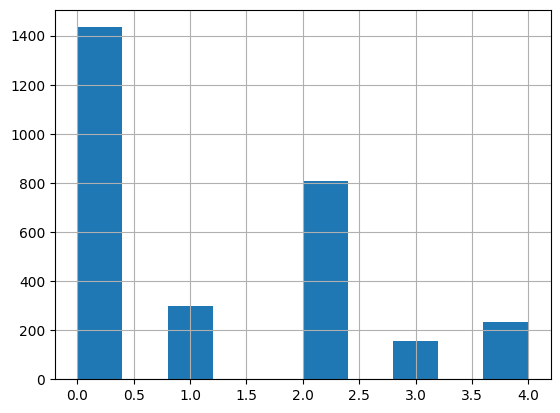

In [4]:
train_df['diagnosis'].value_counts()
train_df['diagnosis'].hist()

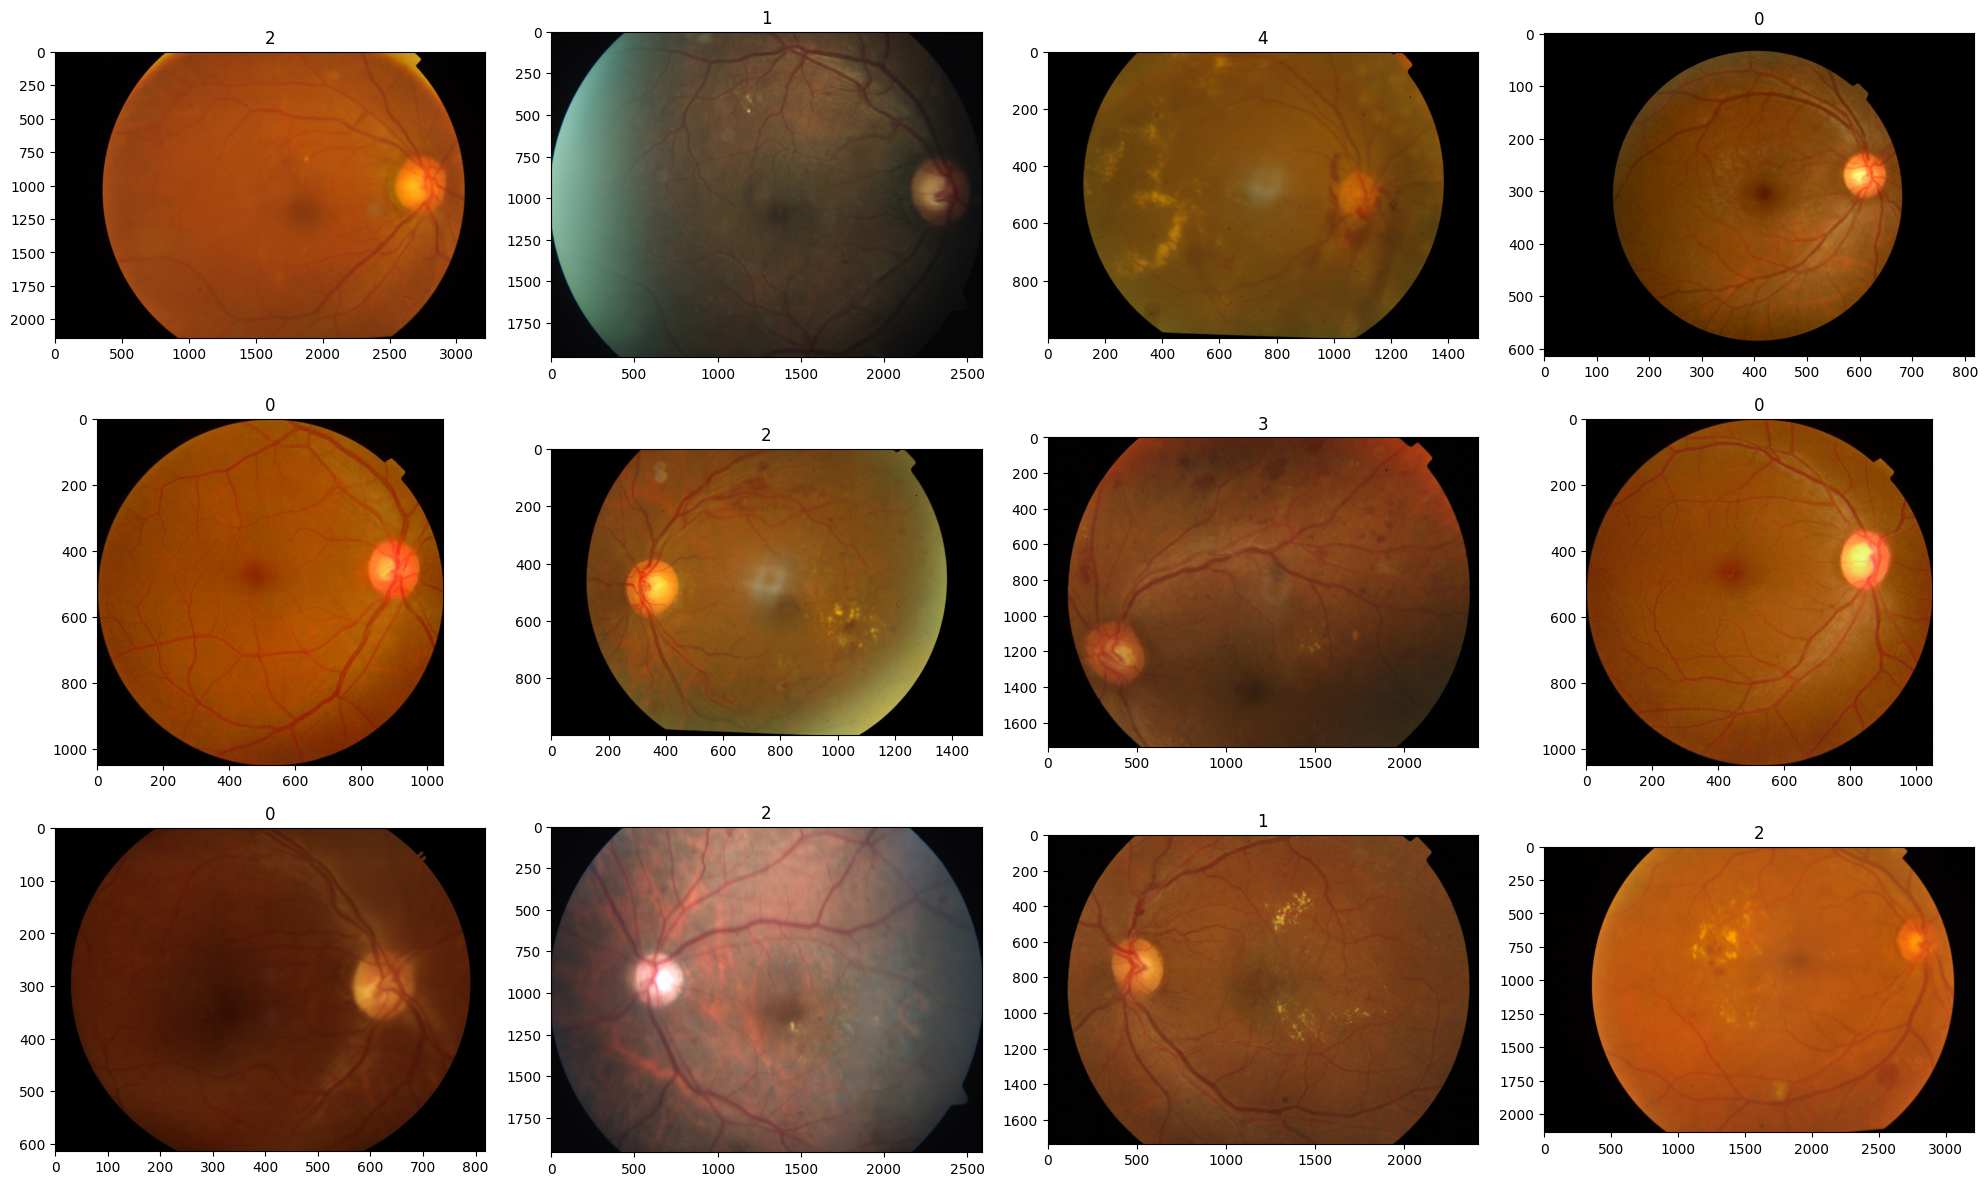

In [ ]:
columns=4
rows=3
fig=plt.figure(figsize=(5*columns, 4*rows))
for i in range(columns*rows):
      image_path = train_df.loc[i,'id_code']
      image_id = train_df.loc[i,'diagnosis']
      img = cv2.imread(f'/content/drive/MyDrive/aptos 2019/train_images/train_images/{image_path}.png')
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      fig.add_subplot(rows, columns, i+1)
      plt.title(image_id)
      plt.imshow(img)
plt.tight_layout()

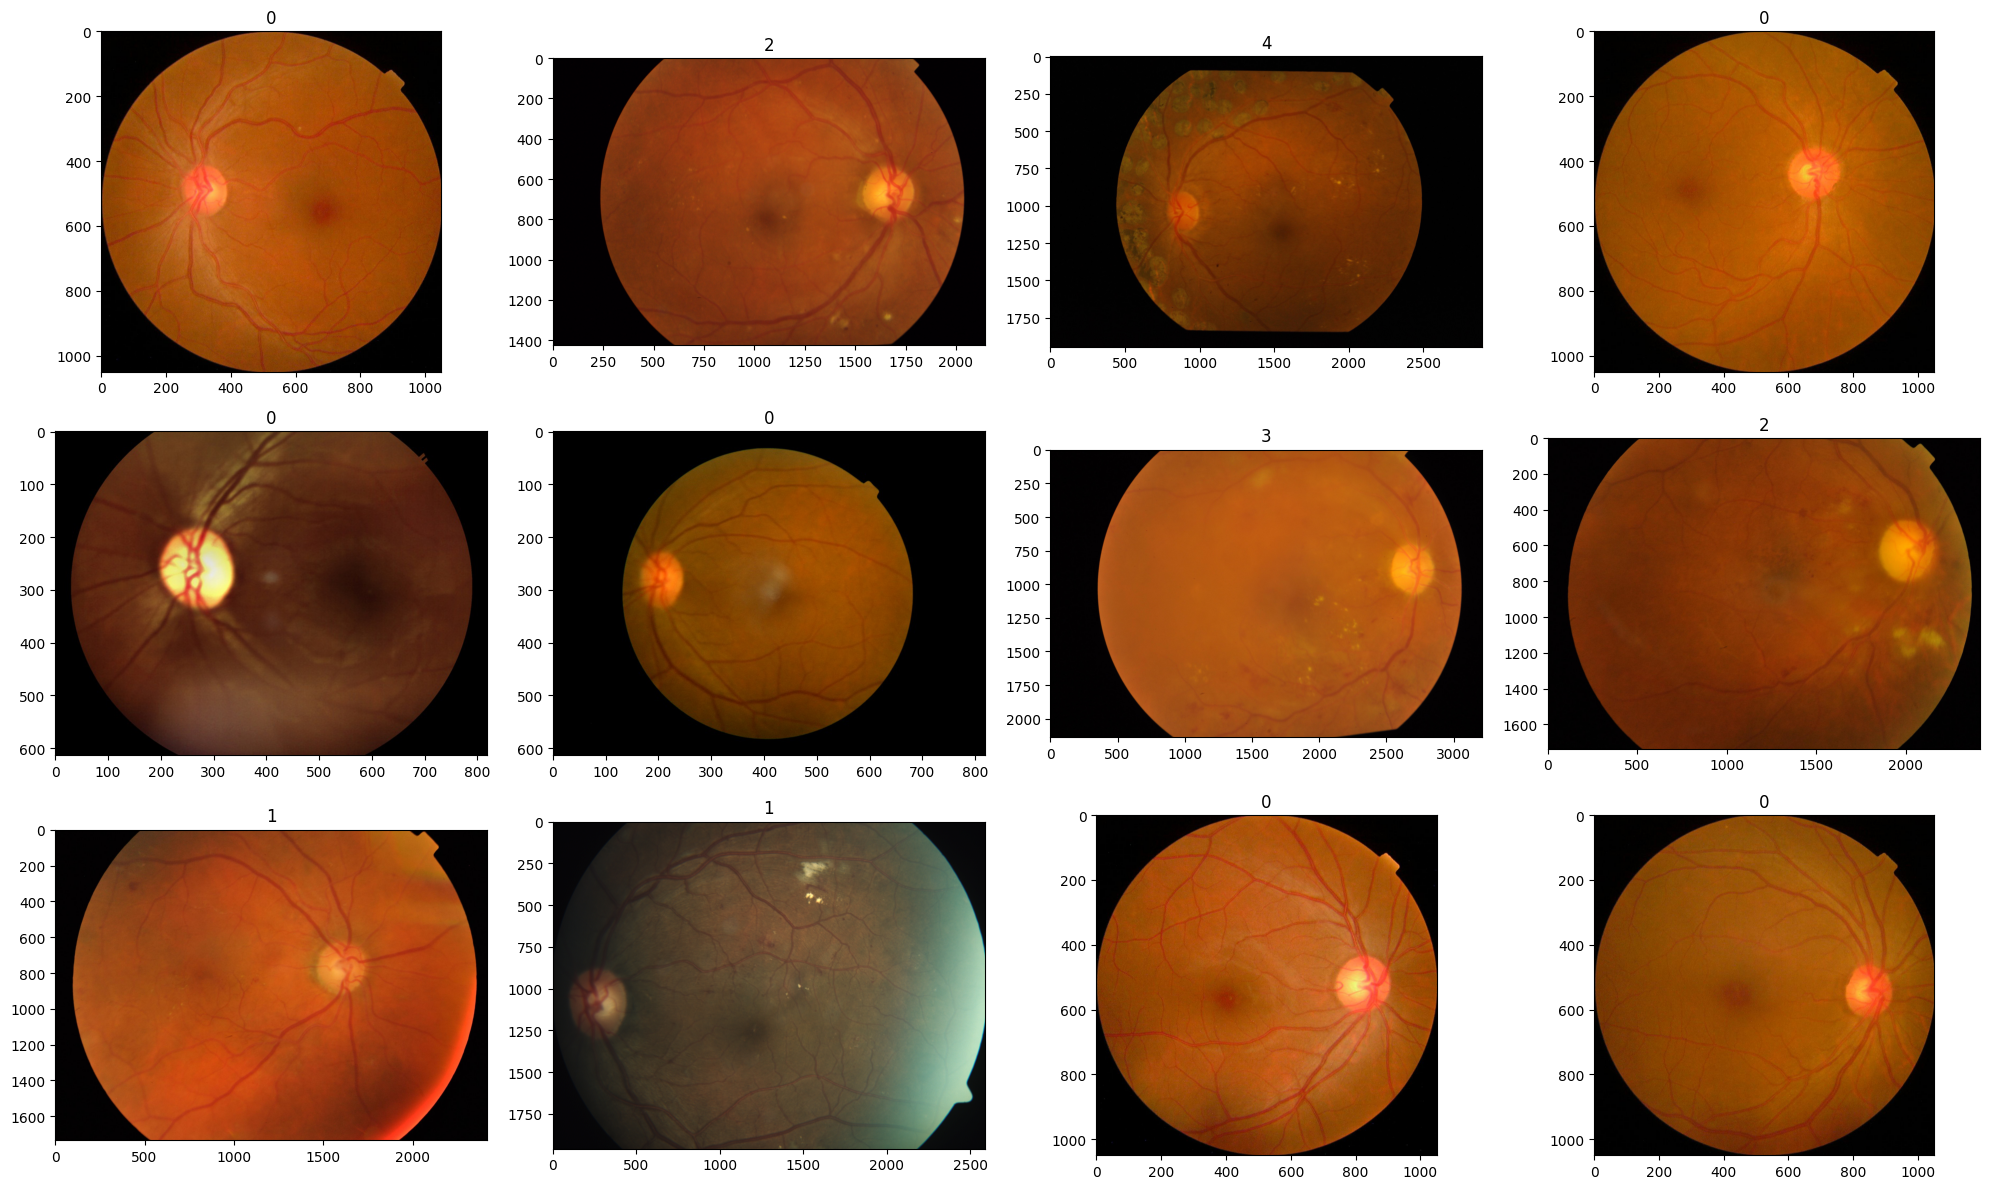

In [ ]:
columns=4
rows=3
fig=plt.figure(figsize=(5*columns, 4*rows))
for i in range(columns*rows):
      image_path = test_df.loc[i,'id_code']
      image_id = test_df.loc[i,'diagnosis']
      img = cv2.imread(f'/content/drive/MyDrive/aptos 2019/test_images/test_images/{image_path}.png')
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      fig.add_subplot(rows, columns, i+1)
      plt.title(image_id)
      plt.imshow(img)
plt.tight_layout()

In [ ]:
def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.BILINEAR)

    return im
N = test_df.shape[0]
x_val = np.empty((N, 224, 224, 3), dtype=np.float32)

for i, image_id in enumerate(tqdm(test_df['id_code'])):#/content/drive/MyDrive/aptos 2019/test_images/test_images/e4dcca36ceb4.png
    x_val[i, :, :, :] = preprocess_image(
        f'/content/drive/MyDrive/aptos 2019/test_images/test_images/{image_id}.png'
    )

100%|██████████| 366/366 [02:38<00:00,  2.31it/s]


In [ ]:
np.save(f'/content/drive/MyDrive/aptos 2019/x_val',x_val)

In [ ]:
def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.BILINEAR)

    return im

N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.float32)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
  x_train[i, :, :, :] = preprocess_image(
                        f'/content/drive/MyDrive/aptos 2019/train_images/train_images/{image_id}.png')

100%|██████████| 2930/2930 [20:57<00:00,  2.33it/s]


In [ ]:
np.save(f'/content/drive/MyDrive/aptos 2019/x_train',x_train)

In [ ]:
def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.BILINEAR)

    return im
N = test_df.shape[0]
x_valid = np.empty((N, 224, 224, 3), dtype=np.float32)

for i, image_id in enumerate(tqdm(valid_df['id_code'])):#/content/drive/MyDrive/aptos 2019/test_images/test_images/e4dcca36ceb4.png
    x_valid[i, :, :, :] = preprocess_image(
        f'/content/drive/MyDrive/aptos 2019/val_images/val_images/{image_id}.png'
    )

100%|██████████| 366/366 [02:52<00:00,  2.13it/s]


In [ ]:
np.save(f'/content/drive/MyDrive/aptos 2019/x_valid',x_valid)

NameError: name 'x_valid' is not defined

In [5]:
x_train=np.load(f'/content/drive/MyDrive/aptos 2019/x_train.npy')

In [6]:
x_val=np.load(f'/content/drive/MyDrive/aptos 2019/x_val.npy')

In [7]:
x_valid=np.load(f'/content/drive/MyDrive/aptos 2019/x_valid.npy')

In [8]:
y_train = train_df['diagnosis']
y_val = test_df['diagnosis']
y_valid=valid_df['diagnosis']
#print(x_train.shape)
print(y_train.shape)
#print(x_val.shape)
print(y_val.shape)
print(y_valid.shape)

(2930,)
(366,)
(366,)


In [ ]:
from tensorflow.keras.applications import VGG19
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load VGG19 base model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features using VGG19
train_features = base_model.predict(x_train)
val_features = base_model.predict(x_val)

# Flatten or reshape the features
train_features_flat = train_features.reshape(train_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(train_features_flat, y_train)

# Predict on validation set
val_predictions = clf.predict(val_features_flat)

# Evaluate the model
val_accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation Accuracy: {val_accuracy}')
print(classification_report(y_val, val_predictions))
print(confusion_matrix(y_val, val_predictions))

92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 240ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 762ms/step
Validation Accuracy: 0.7759562841530054
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       199
           1       0.50      0.23      0.32        30
           2       0.57      0.87      0.69        87
           3       0.33      0.12      0.17        17
           4       0.75      0.09      0.16        33

    accuracy                           0.78       366
   macro avg       0.62      0.46      0.46       366
weighted avg       0.77      0.78      0.74       366

[[196   2   1   0   0]
 [  6   7  17   0   0]
 [  6   3  76   2   0]
 [  0   0  14   2   1]
 [  1   2  25   2   3]]


In [ ]:
BATCH_SIZE=32
from keras.applications import VGG19
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)  # assuming 2 classes (e.g., diabetic vs. non-diabetic)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
BATCH_SIZE=32
from keras.applications import VGG19
import tensorflow as tf
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)  # assuming 2 classes (e.g., diabetic vs. non-diabetic)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
history = model.fit(
    x_train,y_train,
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE, #Corrected this line
    epochs=10,
    validation_data=(x_val, y_val)
)


Epoch 1/10
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.6198 - loss: 1.3594

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


91/91 ━━━━━━━━━━━━━━━━━━━━ 49s 383ms/step - accuracy: 0.6212 - loss: 1.3515 - val_accuracy: 0.7514 - val_loss: 0.6914
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 53s 210ms/step - accuracy: 0.7722 - loss: 0.6383 - val_accuracy: 0.7322 - val_loss: 0.6637
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 21s 216ms/step - accuracy: 0.7874 - loss: 0.5803 - val_accuracy: 0.7814 - val_loss: 0.5942
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - accuracy: 0.8042 - loss: 0.5093 - val_accuracy: 0.7896 - val_loss: 0.6190
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 207ms/step - accuracy: 0.8238 - loss: 0.4755 - val_accuracy: 0.7760 - val_loss: 0.6490
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.8189 - loss: 0.4633 - val_accuracy: 0.7623 - val_loss: 0.6839
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8343 - loss: 0.4612 - val_accuracy: 0.7760 - val_loss: 0.6408
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - accuracy: 0.8378 - loss: 0.4258 - val_accuracy: 0.789

In [ ]:
model.evaluate(x_valid,y_valid)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.7665 - loss: 0.6789


[0.6739904880523682, 0.7650273442268372]

In [ ]:
BATCH_SIZE=32
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)  # assuming 2 classes (e.g., diabetic vs. non-diabetic)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
h1 = model.fit(
    x_train,y_train,
    # Use integer division (//) to ensure steps_per_epoch is an integer
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_data=(x_val, y_val)
)

Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 33s 233ms/step - accuracy: 0.6569 - loss: 0.9088 - val_accuracy: 0.7869 - val_loss: 0.5793
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6667 - loss: 1.0007 - val_accuracy: 0.7896 - val_loss: 0.5823
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.7860 - loss: 0.5691 - val_accuracy: 0.8115 - val_loss: 0.5411
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7222 - loss: 0.7843 - val_accuracy: 0.8087 - val_loss: 0.5618
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - accuracy: 0.8090 - loss: 0.5264 - val_accuracy: 0.8361 - val_loss: 0.5068
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7222 - loss: 0.7816 - val_accuracy: 0.8197 - val_loss: 0.5306
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.8303 - loss: 0.4551 - val_accuracy: 0.8333 - val_loss: 0.5301
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8889 - loss: 0.2550 - val_accuracy: 0.

In [ ]:
model.evaluate(x_valid,y_valid)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.8108 - loss: 0.5841


[0.5694684386253357, 0.8087431788444519]

In [ ]:
BATCH_SIZE = 32
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)  # assuming 5 classes
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
h1 = model.fit(
    x_train,y_train,
    # Use floor division (//) to ensure steps_per_epoch is an integer
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_data=(x_val, y_val)
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.6407 - loss: 0.9969 - val_accuracy: 0.7541 - val_loss: 0.7187
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7778 - loss: 0.4956 - val_accuracy: 0.7596 - val_loss: 0.7180
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.7289 - loss: 0.7427 - val_accuracy: 0.7568 - val_loss: 0.7027
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7778 - loss: 0.6174 - val_accuracy: 0.7514 - val_loss: 0.7119
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.7414 - loss: 0.6929 - val_accuracy: 0.7514 - val_loss: 0.6747
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6111 - loss: 0.9952 - val_accuracy: 0.7514 - val_loss: 0.6700
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7573 - loss: 0.6855 - val_accuracy: 0.7541 - val_loss: 0.6850
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0

In [ ]:
model.evaluate(x_valid,y_valid)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7427 - loss: 0.7059


[0.7062857151031494, 0.7322404384613037]

In [ ]:
BATCH_SIZE = 32
import tensorflow as tf
from tensorflow.keras.applications import Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)  # assuming 5 classes
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
h1 = model.fit(
    x_train,y_train,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_data=(x_val, y_val)
)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 51s 342ms/step - accuracy: 0.4627 - loss: 4.8953 - val_accuracy: 0.6776 - val_loss: 0.9272
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 139ms/step - accuracy: 0.6420 - loss: 1.0036 - val_accuracy: 0.6667 - val_loss: 0.8087
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step - accuracy: 0.7058 - loss: 0.8226 - val_accuracy: 0.7213 - val_loss: 0.7536
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.7260 - loss: 0.7817 - val_accuracy: 0.7240 - val_loss: 0.8139
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.7071 - loss: 0.8087 - val_accuracy: 0.7295 - val_loss: 0.7975
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.7160 - loss: 0.7892 - val_accuracy: 0.7295 - val_loss: 0.7345
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.7153 - loss: 0.7568 - val_accuracy: 0.7213 - val_loss: 0.7533
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 143m

In [ ]:
model.evaluate(x_valid,y_valid)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.7259 - loss: 0.8077


[0.8117918372154236, 0.7158470153808594]

In [ ]:
BATCH_SIZE = 32
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)  # assuming 5 classes
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
h1 = model.fit(
    x_train,y_train,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_data=(x_val, y_val)
)


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 573ms/step - accuracy: 0.3794 - loss: 24.4722 - val_accuracy: 0.5437 - val_loss: 1.7683
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 182ms/step - accuracy: 0.4700 - loss: 2.4302 - val_accuracy: 0.3770 - val_loss: 1.3683
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.5467 - loss: 1.5125 - val_accuracy: 0.4699 - val_loss: 1.4445
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - accuracy: 0.5014 - loss: 1.9564 - val_accuracy: 0.5820 - val_loss: 1.1833
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 180ms/step - accuracy: 0.5321 - loss: 1.4623 - val_accuracy: 0.6011 - val_loss: 1.0668
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - accuracy: 0.5756 - loss: 1.2753 - val_accuracy: 0.5956 - val_loss: 1.1465
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - accuracy: 0.6089 - loss: 1.2040 - val_accuracy: 0.6421 - val_loss: 0.9425
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 1

In [ ]:
model.evaluate(x_valid,y_valid)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.6228 - loss: 1.1429


[1.1126914024353027, 0.6338797807693481]

In [ ]:
from tensorflow.keras.applications import VGG19
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load VGG19 base model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features using VGG19
train_features = base_model.predict(x_train)
val_features = base_model.predict(x_val)

# Flatten or reshape the features
train_features_flat = train_features.reshape(train_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(train_features_flat, y_train)

# Predict on validation set
val_predictions = clf.predict(val_features_flat)

# Evaluate the model
val_accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation Accuracy: {val_accuracy}')
print(classification_report(y_val, val_predictions))
print(confusion_matrix(y_val, val_predictions))


92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 185ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step
Validation Accuracy: 0.7759562841530054
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       199
           1       0.54      0.23      0.33        30
           2       0.57      0.87      0.69        87
           3       0.33      0.12      0.17        17
           4       0.75      0.09      0.16        33

    accuracy                           0.78       366
   macro avg       0.63      0.46      0.46       366
weighted avg       0.77      0.78      0.73       366

[[196   2   1   0   0]
 [  6   7  17   0   0]
 [  7   2  76   2   0]
 [  0   0  14   2   1]
 [  1   2  25   2   3]]


In [ ]:
valid_features= base_model.predict(x_valid)
valid_features_flat = valid_features.reshape(valid_features.shape[0], -1)
valid_predictions = clf.predict(valid_features_flat)
valid_accuracy = accuracy_score(y_valid, valid_predictions)
print(f'Validation Accuracy: {valid_accuracy}')
print(classification_report(y_valid, valid_predictions))
print(confusion_matrix(y_valid, valid_predictions))

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step
Validation Accuracy: 0.7622950819672131
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       172
           1       0.65      0.28      0.39        40
           2       0.59      0.88      0.70       104
           3       0.67      0.09      0.16        22
           4       1.00      0.14      0.25        28

    accuracy                           0.76       366
   macro avg       0.76      0.48      0.49       366
weighted avg       0.78      0.76      0.72       366

[[171   0   1   0   0]
 [  4  11  25   0   0]
 [  8   5  91   0   0]
 [  1   0  19   2   0]
 [  3   1  19   1   4]]


In [ ]:
from tensorflow.keras.applications import ResNet50
from sklearn.ensemble import RandomForestClassifier
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features using VGG19
train_features = base_model.predict(x_train)
val_features = base_model.predict(x_val)

# Flatten or reshape the features
train_features_flat = train_features.reshape(train_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(train_features_flat, y_train)

# Predict on validation set
val_predictions = clf.predict(val_features_flat)

# Evaluate the model
val_accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation Accuracy: {val_accuracy}')
print(classification_report(y_val, val_predictions))
print(confusion_matrix(y_val, val_predictions))

92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 317ms/step
Validation Accuracy: 0.7896174863387978
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       199
           1       0.83      0.33      0.48        30
           2       0.58      0.91      0.71        87
           3       0.33      0.12      0.17        17
           4       0.75      0.09      0.16        33

    accuracy                           0.79       366
   macro avg       0.69      0.49      0.50       366
weighted avg       0.80      0.79      0.75       366

[[195   1   3   0   0]
 [  6  10  14   0   0]
 [  5   1  79   2   0]
 [  0   0  14   2   1]
 [  1   0  27   2   3]]


In [ ]:
valid_features= base_model.predict(x_valid)
valid_features_flat = valid_features.reshape(valid_features.shape[0], -1)
valid_predictions = clf.predict(valid_features_flat)
valid_accuracy = accuracy_score(y_valid, valid_predictions)
print(f'Validation Accuracy: {valid_accuracy}')
print(classification_report(y_valid, valid_predictions))
print(confusion_matrix(y_valid, valid_predictions))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
Validation Accuracy: 0.7704918032786885
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       172
           1       0.67      0.40      0.50        40
           2       0.59      0.85      0.70       104
           3       0.67      0.09      0.16        22
           4       0.83      0.18      0.29        28

    accuracy                           0.77       366
   macro avg       0.74      0.50      0.52       366
weighted avg       0.78      0.77      0.74       366

[[171   1   0   0   0]
 [  1  16  22   0   1]
 [ 10   6  88   0   0]
 [  1   0  19   2   0]
 [  2   1  19   1   5]]


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features using MobileNetV2
train_features = base_model.predict(x_train)
val_features = base_model.predict(x_val)

# Flatten or reshape the features
train_features_flat = train_features.reshape(train_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(train_features_flat, y_train)

# Predict on validation set
val_predictions = clf.predict(val_features_flat)

# Evaluate the model
val_accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation Accuracy: {val_accuracy}')
print(classification_report(y_val, val_predictions))
print(confusion_matrix(y_val, val_predictions))


92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step
Validation Accuracy: 0.7650273224043715
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       199
           1       0.50      0.30      0.38        30
           2       0.55      0.84      0.66        87
           3       0.20      0.06      0.09        17
           4       0.75      0.09      0.16        33

    accuracy                           0.77       366
   macro avg       0.59      0.45      0.45       366
weighted avg       0.76      0.77      0.73       366

[[194   1   4   0   0]
 [  4   9  17   0   0]
 [  7   5  73   2   0]
 [  1   0  14   1   1]
 [  0   3  25   2   3]]


In [ ]:
model.evaluate(x_valid,y_valid)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.7887 - loss: 0.5786


[0.5671918392181396, 0.8005464673042297]

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load InceptionResNetV2 base model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features using InceptionResNetV2
train_features = base_model.predict(x_train)
val_features = base_model.predict(x_val)

# Flatten or reshape the features
train_features_flat = train_features.reshape(train_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(train_features_flat, y_train)

# Predict on validation set
val_predictions = clf.predict(val_features_flat)

# Evaluate the model
val_accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation Accuracy: {val_accuracy}')
print(classification_report(y_val, val_predictions))
print(confusion_matrix(y_val, val_predictions))


92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 301ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 878ms/step
Validation Accuracy: 0.7431693989071039
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       199
           1       0.58      0.23      0.33        30
           2       0.55      0.84      0.66        87
           3       0.50      0.06      0.11        17
           4       0.43      0.09      0.15        33

    accuracy                           0.74       366
   macro avg       0.59      0.43      0.43       366
weighted avg       0.72      0.74      0.70       366

[[188   3   8   0   0]
 [  7   7  16   0   0]
 [ 10   1  73   1   2]
 [  3   0  11   1   2]
 [  4   1  25   0   3]]


In [ ]:
valid_features= base_model.predict(x_valid)
valid_features_flat = valid_features.reshape(valid_features.shape[0], -1)
valid_predictions = clf.predict(valid_features_flat)
valid_accuracy = accuracy_score(y_valid, valid_predictions)
print(f'Validation Accuracy: {valid_accuracy}')
print(classification_report(y_valid, valid_predictions))
print(confusion_matrix(y_valid, valid_predictions))

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step
Validation Accuracy: 0.7240437158469946
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       172
           1       0.55      0.28      0.37        40
           2       0.56      0.82      0.67       104
           3       0.33      0.05      0.08        22
           4       1.00      0.11      0.19        28

    accuracy                           0.72       366
   macro avg       0.66      0.44      0.44       366
weighted avg       0.73      0.72      0.68       366

[[165   1   6   0   0]
 [  3  11  26   0   0]
 [ 15   4  85   0   0]
 [  3   2  16   1   0]
 [  3   2  18   2   3]]


In [ ]:
from tensorflow.keras.applications import ResNet50,VGG19
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_features(model, x_data):
    features = model.predict(x_data, batch_size=32, verbose=1)
    features_flattened = features.reshape((features.shape[0], -1))
    return features_flattened

# Assuming x_train and x_val are your image data loaded and preprocessed as per your code
x_train_vgg19_features = extract_features(vgg19, x_train)
x_val_vgg19_features = extract_features(vgg19, x_val)

x_train_resnet50_features = extract_features(resnet50, x_train)
x_val_resnet50_features = extract_features(resnet50, x_val)

# Combine features
x_train_combined = np.hstack((x_train_vgg19_features, x_train_resnet50_features))
x_val_combined = np.hstack((x_val_vgg19_features, x_val_resnet50_features))


input_shape = x_train_combined.shape[1]
model = Sequential([
   # Flatten layer to reshape input, if needed (e.g., for images)
    Dense(512, activation='relu',input_shape=(input_shape,)),  # 1st hidden layer
    Dense(256, activation='relu'),  # 2nd hidden layer
    Dense(128, activation='relu'),  # 3rd hidden layer
    Dense(64, activation='relu'),   # 4th hidden layer
    Dense(32, activation='relu'),   # 5th hidden layer
    Dense(5, activation='softmax')  # Output layer
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

BATCH_SIZE=32
history = model.fit(
    x_train_combined,y_train,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE, #3fc,1pool,3fc
    epochs=10,
    validation_data=(x_val_combined, y_val)
)

In [ ]:
model.evaluate(x_valid,y_valid)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam

# Load VGG19 as the base model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of VGG19
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of VGG19
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert features to vectors

# A Dense layer to mimic SVM's hyperplane. Note: For binary classification, use 1 unit and for multi-class, use 'n_classes' units
n_classes = len(np.unique(y_train))  # Assuming y_train is your label array
x = Dense(n_classes, activation='linear')(x)  # Linear activation to mimic the SVM hyperplane

# Final model
model = Model(inputs=base_model.input, outputs=x)

# Custom hinge loss for the SVM-like behavior
def hinge_loss(y_true, y_pred):
    return tf.reduce_mean(tf.maximum(1. - y_true * y_pred, 0.))

model.compile(optimizer=Adam(learning_rate=0.0001), loss=hinge_loss, metrics=['accuracy'])

# Convert labels for hinge loss (assumes y_train and y_val are initially in categorical format)
y_train_hinge = 2 * y_train - 1  # Convert labels to -1 or 1
y_val_hinge = 2 * y_val - 1

# Train model
model.fit(x_train, y_train_hinge, batch_size=32, epochs=10, validation_data=(x_val, y_val_hinge))


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 66s 537ms/step - accuracy: 0.0181 - loss: 2.9695 - val_accuracy: 0.0984 - val_loss: 1.4075
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 193ms/step - accuracy: 0.0748 - loss: 1.2672 - val_accuracy: 0.1148 - val_loss: 1.0555
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 207ms/step - accuracy: 0.0825 - loss: 0.9587 - val_accuracy: 0.1230 - val_loss: 0.8156
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.0950 - loss: 0.7403 - val_accuracy: 0.1230 - val_loss: 0.6648
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 184ms/step - accuracy: 0.0829 - loss: 0.6125 - val_accuracy: 0.1175 - val_loss: 0.5783
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 193ms/step - accuracy: 0.0754 - loss: 0.5730 - val_accuracy: 0.1284 - val_loss: 0.5198
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 197ms/step - accuracy: 0.0884 - loss: 0.4826 - val_accuracy: 0.1202 - val_loss: 0.4772
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - accuracy: 0.0912 - loss: 0.4423 - val_accu

In [10]:
from tensorflow.keras.applications import Xception, InceptionResNetV2
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load Xception and InceptionResNetV2 models
xception = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_resnet_v2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_features(model, x_data):
    features = model.predict(x_data, batch_size=32, verbose=1)
    features_flattened = features.reshape((features.shape[0], -1))
    return features_flattened

# Assuming x_train and x_val are your image data loaded and preprocessed as per your code
x_train_xception_features = extract_features(xception, x_train)
x_val_xception_features = extract_features(xception, x_val)

x_train_inception_resnet_v2_features = extract_features(inception_resnet_v2, x_train)
x_val_inception_resnet_v2_features = extract_features(inception_resnet_v2, x_val)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 177ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 530ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 285ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 832ms/step


In [11]:
import numpy as np
np.save("/content/drive/MyDrive/aptos 2019/x_train_inception_resnet_v2_features.npy",x_train_inception_resnet_v2_features)
np.save("/content/drive/MyDrive/aptos 2019/x_val_inception_resnet_v2_features.npy",x_val_inception_resnet_v2_features)
np.save("/content/drive/MyDrive/aptos 2019/x_train_xception_features.npy",x_train_xception_features)
np.save("/content/drive/MyDrive/aptos 2019/x_val_xception_features.npy",x_val_xception_features)

In [12]:
x_train_inception_resnet_v2_features=np.load("/content/drive/MyDrive/aptos 2019/x_train_inception_resnet_v2_features.npy")
x_val_inception_resnet_v2_features=np.load("/content/drive/MyDrive/aptos 2019/x_val_inception_resnet_v2_features.npy")
x_train_xception_features=np.load("/content/drive/MyDrive/aptos 2019/x_train_xception_features.npy")
x_val_xception_features=np.load("/content/drive/MyDrive/aptos 2019/x_val_xception_features.npy")

In [14]:
x_valid=np.load("/content/drive/MyDrive/aptos 2019/x_valid.npy")
from tensorflow.keras.applications import Xception, InceptionResNetV2
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load Xception and InceptionResNetV2 models
xception = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_resnet_v2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_features(model, x_data):
    features = model.predict(x_data, batch_size=32, verbose=1)
    features_flattened = features.reshape((features.shape[0], -1))
    return features_flattened

# Assuming x_train and x_val are your image data loaded and preprocessed as per your code
x_valid_xception_features = extract_features(xception, x_valid)
x_valid_inception_resnet_v2_features = extract_features(inception_resnet_v2, x_valid)

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step


In [15]:
import numpy as np
np.save("/content/drive/MyDrive/aptos 2019/x_valid_xception_features.npy",x_valid_xception_features)
np.save("/content/drive/MyDrive/aptos 2019/x_valid_inception_resnet_v2_features.npy",x_valid_inception_resnet_v2_features)

In [16]:
x_valid_xception_features=np.load("/content/drive/MyDrive/aptos 2019/x_valid_xception_features.npy")
x_valid_inception_resnet_v2_features=np.load("/content/drive/MyDrive/aptos 2019/x_valid_inception_resnet_v2_features.npy")

In [ ]:
# Combine features
x_train_combined = np.hstack((x_train_xception_features, x_train_inception_resnet_v2_features))
x_val_combined = np.hstack((x_val_xception_features, x_val_inception_resnet_v2_features))

# Model training
input_shape = x_train_combined.shape[1]
model = Sequential([
    Dense(512, activation='relu', input_shape=(input_shape,)),  # 1st hidden layer
    Dense(256, activation='relu'),  # 2nd hidden layer
    Dense(128, activation='relu'),  # 3rd hidden layer
    Dense(64, activation='relu'),   # 4th hidden layer
    Dense(32, activation='relu'),   # 5th hidden layer
    Dense(5, activation='softmax')  # Output layer
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 32
history = model.fit(
    x_train_combined, y_train,batch_size=BATCH_SIZE,
    steps_per_epoch=x_train_combined.shape[0] // BATCH_SIZE,
    epochs=20,
    validation_data=(x_val_combined, y_val)
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [1]:
x_valid_combined = np.hstack((x_valid_xception_features, x_valid_inception_resnet_v2_features))
model.evaluate(x_valid_combined,y_valid)


NameError: name 'np' is not defined

In [ ]:
from tensorflow.keras.layers import Input, Concatenate, Dense
from tensorflow.keras.models import Model
BATCH_SIZE=32
# Define input layers for VGG19 and ResNet50 features
input_xception = Input(shape=(x_train_xception_features.shape[1],))
input_inception_resnet_v2 = Input(shape=(x_train_inception_resnet_v2_features.shape[1],))

# Define the neural network layers
dense_1 = Dense(512, activation='relu')(input_xception)
dense_2 = Dense(256, activation='relu')(dense_1)
dense_3 = Dense(256, activation='relu')(dense_2)
dense_03 = Dense(128, activation='relu')(dense_3)
# Cross-pooling layer to combine VGG19 and ResNet50 features
cross_pooled = Concatenate()([dense_03, input_inception_resnet_v2])

dense_4 = Dense(128, activation='relu')(cross_pooled)
dense_04 = Dense(64, activation='relu')(dense_4)
dense_5 = Dense(32, activation='relu')(dense_04)
output = Dense(5, activation='softmax')(dense_5)

# Create the model
model = Model(inputs=[input_xception, input_inception_resnet_v2], outputs=output)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    [x_train_xception_features, x_train_inception_resnet_v2_features], y_train,
    epochs=30,
    validation_data=([x_val_xception_features, x_val_inception_resnet_v2_features], y_val)
)


Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.4259 - loss: 312.1599 - val_accuracy: 0.6011 - val_loss: 36.8601
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5310 - loss: 43.2581 - val_accuracy: 0.5055 - val_loss: 18.4243
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5965 - loss: 21.4319 - val_accuracy: 0.6776 - val_loss: 10.2963
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5882 - loss: 17.6498 - val_accuracy: 0.7077 - val_loss: 33.9807
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6288 - loss: 17.8975 - val_accuracy: 0.4508 - val_loss: 23.4950
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6124 - loss: 12.7923 - val_accuracy: 0.4809 - val_loss: 17.9830
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6101 - loss: 11.3874 - val_accuracy: 0.6011 - val_loss: 8.9417
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6227 - loss: 9.1928 - val_accu

In [ ]:
model.evaluate([x_valid_xception_features, x_valid_inception_resnet_v2_features], y_valid)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6494 - loss: 2.3664


[2.3338730335235596, 0.6693989038467407]

In [ ]:
from tensorflow.keras.layers import Input, Concatenate, Dense
from tensorflow.keras.models import Model
BATCH_SIZE=32
# Define input layers for VGG19 and ResNet50 features
input_xception = Input(shape=(x_train_xception_features.shape[1],))
input_inception_resnet_v2 = Input(shape=(x_train_inception_resnet_v2_features.shape[1],))

# Define the neural network layers
dense_1 = Dense(512, activation='relu')(input_xception)
dense_2 = Dense(256, activation='relu')(dense_1)
dense_3 = Dense(256, activation='relu')(dense_2)
dense_03 = Dense(128, activation='relu')(dense_3)
# Cross-pooling layer to combine VGG19 and ResNet50 features
cross_pooled = Concatenate()([dense_1, input_inception_resnet_v2])

dense_4 = Dense(128, activation='relu')(cross_pooled)
dense_04 = Dense(64, activation='relu')(dense_4)
dense_5 = Dense(32, activation='relu')(dense_04)
output = Dense(5, activation='softmax')(dense_5)

# Create the model
model = Model(inputs=[input_xception, input_inception_resnet_v2], outputs=output)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    [x_train_xception_features, x_train_inception_resnet_v2_features], y_train,
    epochs=30,
    validation_data=([x_val_xception_features, x_val_inception_resnet_v2_features], y_val)
)


Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - accuracy: 0.4353 - loss: 211.2662 - val_accuracy: 0.3634 - val_loss: 40.8594
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.5918 - loss: 33.8984 - val_accuracy: 0.5628 - val_loss: 58.7914
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6067 - loss: 35.3656 - val_accuracy: 0.5055 - val_loss: 52.8191
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5671 - loss: 38.3285 - val_accuracy: 0.5410 - val_loss: 38.9021
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6106 - loss: 25.5468 - val_accuracy: 0.7295 - val_loss: 16.1396
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6053 - loss: 19.3145 - val_accuracy: 0.5437 - val_loss: 24.6556
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6419 - loss: 12.7754 - val_accuracy: 0.7240 - val_loss: 13.1542
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6352 - loss: 10.4594 - val_a

In [ ]:
model.evaluate([x_valid_xception_features, x_valid_inception_resnet_v2_features], y_valid)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5775 - loss: 1.5443


[1.6465634107589722, 0.568306028842926]

In [ ]:
!pip install SENet

ERROR: Could not find a version that satisfies the requirement SENet (from versions: none)
ERROR: No matching distribution found for SENet


In [ ]:
from tensorflow.keras.applications import NASNetLarge, SEnet

ImportError: cannot import name 'SEnet' from 'tensorflow.keras.applications' (/usr/local/lib/python3.10/dist-packages/keras/_tf_keras/keras/applications/__init__.py)

In [ ]:
from tensorflow.keras.applications import NASNetLarge, EfficientNetV2S
import numpy as np

# Load NASNetLarge and SENet with pre-trained ImageNet weights
nasnet = NASNetLarge(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
effnet = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_features(model, x_data):
    features = model.predict(x_data, batch_size=32, verbose=1)
    features_flattened = features.reshape((features.shape[0], -1))
    return features_flattened

# Assuming 'x_valid' is your validation dataset pre-processed to the required input size (e.g., 331x331 for NASNetLarge)
x_test_nasnet_features = extract_features(nasnet, x_val)
x_test_effnet_features = extract_features(effnet, x_val)
x_valid_nasnet_features = extract_features(nasnet, x_valid)
x_valid_effnet_features = extract_features(effnet, x_valid)



12/12 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 434ms/step


In [ ]:
import numpy as np
np.save("/content/drive/MyDrive/aptos 2019/x_train_nasnet_features.npy",x_train_nasnet_features)
np.save("/content/drive/MyDrive/aptos 2019/x_train_effnet_features.npy",x_train_effnet_features)

NameError: name 'x_train_nasnet_features' is not defined

In [ ]:
import numpy as np
np.save("/content/drive/MyDrive/aptos 2019/x_test_nasnet_features.npy",x_test_nasnet_features)
np.save("/content/drive/MyDrive/aptos 2019/x_test_effnet_features.npy",x_test_effnet_features)
np.save("/content/drive/MyDrive/aptos 2019/x_valid_nasnet_features.npy",x_valid_nasnet_features)
np.save("/content/drive/MyDrive/aptos 2019/x_valid_effnet_features.npy",x_valid_effnet_features)

In [ ]:
x_test_nasnet_features = extract_features(nasnet, x_val)
x_test_effnet_features = extract_features(effnet, x_val)
x_valid_nasnet_features = extract_features(nasnet, x_valid)
x_valid_effnet_features = extract_features(effnet, x_valid)

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 316ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


In [ ]:
x_train_nasnet_features=np.load("/content/drive/MyDrive/aptos 2019/x_train_nasnet_features.npy")
x_train_effnet_features=np.load("/content/drive/MyDrive/aptos 2019/x_train_effnet_features.npy")
x_test_nasnet_features=np.load("/content/drive/MyDrive/aptos 2019/x_test_nasnet_features.npy")
x_test_effnet_features=np.load("/content/drive/MyDrive/aptos 2019/x_test_effnet_features.npy")
x_valid_nasnet_features=np.load("/content/drive/MyDrive/aptos 2019/x_valid_nasnet_features.npy")
x_valid_effnet_features=np.load("/content/drive/MyDrive/aptos 2019/x_valid_effnet_features.npy")

ValueError: cannot reshape array of size 104674035 into shape (2930,197568)

In [ ]:
from tensorflow.keras.layers import Input, Concatenate, Dense
from tensorflow.keras.models import Model
BATCH_SIZE=16
# Define input layers for VGG19 and ResNet50 features
input_nasnet = Input(shape=(x_train_nasnet_features.shape[1],))
input_effnet = Input(shape=(x_train_effnet_features.shape[1],))

# Define the neural network layers
dense_1 = Dense(512, activation='relu')(input_nasnet)
dense_2 = Dense(256, activation='relu')(dense_1)
dense_3 = Dense(256, activation='relu')(dense_2)
dense_03 = Dense(128, activation='relu')(dense_3)
# Cross-pooling layer to combine VGG19 and ResNet50 features
cross_pooled = Concatenate()([dense_1, input_effnet])

dense_4 = Dense(128, activation='relu')(cross_pooled)
dense_04 = Dense(64, activation='relu')(dense_4)
dense_5 = Dense(32, activation='relu')(dense_04)
output = Dense(5, activation='softmax')(dense_5)

# Create the model
model = Model(inputs=[input_nasnet, input_effnet], outputs=output)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    [x_train_nasnet_features, x_train_effnet_features], y_train,
    steps_per_epoch=x_train_nasnet_features.shape[0] / BATCH_SIZE,batch_size=BATCH_SIZE,
    epochs=50,
    validation_data=([x_test_nasnet_features, x_test_effnet_features], y_val)
)


NameError: name 'x_train_nasnet_features' is not defined

In [ ]:
model.evaluate([x_valid_nasnet_features, x_valid_effnet_features],y_valid)